In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import scipy.io as sio
import os
import random

import torch
from fastai.data_block import DataBunch
from fastai.metrics import accuracy
from fastai.vision import Learner
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils import data
from fastai.vision import *

from matplotlib.colors import is_color_like

In [0]:
from google.colab import drive
drive.mount('/content/drive')

path = Path('drive/My Drive/Colab Notebooks/Neuroscience/data/normal/11x12x12')

filenames = [file.name.split('_')[0] for file in os.scandir(path) if file.name.endswith('labels.npy')]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
array = np.load(path/f"{filenames[0]}_labels.npy", allow_pickle=True)
encoder = LabelEncoder()

encoded = encoder.fit_transform(array)
np.save(path/f"{filenames[0].split('.')[0]}_coded_labels.npy", encoded)

In [0]:
class MouseDataset(data.Dataset):
    def __init__(self, path, filename, split='train'):
        super().__init__()
        self.is_empty = False
        random.seed(123)
        self.data = np.load(path/f"{filename}.npy")
        self.labels = np.load(path/f"{filename}_coded_labels.npy", allow_pickle=True)
        
        
        train_indices = random.sample(range(len(self.data)), round(0.66 * len(self.data)))
        if split == 'train':
            self.data = self.data[train_indices]
            self.labels = self.labels[train_indices]
        else:
            all_indices = [index for index in range(len(self.data))]
            test_indices = list(set(all_indices).difference(set(train_indices)))
            self.data = self.data[test_indices]
            self.labels = self.labels[test_indices]
  
    def __getitem__(self, index):
      data = torch.from_numpy(self.data[index].astype(np.float32))
      data = data.view(1, *data.size())
      label = torch.from_numpy(np.array([self.labels[index]]).astype(np.long))
      return data, label.squeeze_()

    def __len__(self):
        return len(self.data)

In [0]:
import torch.nn as nn

class MouseNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm3d(16),
        nn.ReLU(inplace=True),
        nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace=True),
        nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace=True),
        nn.Conv3d(32, 32, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace=True),
        nn.AvgPool3d(kernel_size=3),
        nn.Flatten(),
        nn.Linear(32, 13)
    )
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

  def forward(self, x):
    return self.network(x)

In [0]:
train_ds = MouseDataset(path, filenames[0], 'train')
test_ds = MouseDataset(path, filenames[0], 'test')
bunch = DataBunch.create(train_ds, test_ds)
model = MouseNet()
learner = Learner(data=bunch, model=model, loss_func=CrossEntropyLoss(), metrics=accuracy)

In [0]:
learner.summary()

MouseNet
Layer (type)         Output Shape         Param #    Trainable 
Conv3d               [16, 11, 12, 12]     432        True      
______________________________________________________________________
BatchNorm3d          [16, 11, 12, 12]     32         True      
______________________________________________________________________
ReLU                 [16, 11, 12, 12]     0          False     
______________________________________________________________________
Conv3d               [32, 6, 6, 6]        13,824     True      
______________________________________________________________________
BatchNorm3d          [32, 6, 6, 6]        64         True      
______________________________________________________________________
ReLU                 [32, 6, 6, 6]        0          False     
______________________________________________________________________
Conv3d               [32, 6, 6, 6]        27,648     True      
_____________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


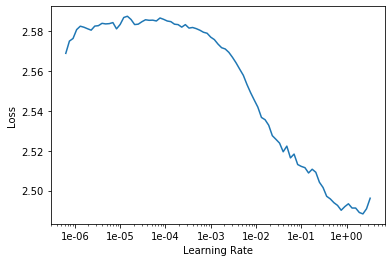

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(10, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,2.433368,2.721801,0.086389,00:00
1,2.337516,2.348897,0.161820,00:00
2,2.277611,2.363250,0.168984,00:00
3,2.201040,2.323455,0.176570,00:00
4,2.106348,2.355371,0.190898,00:00
5,1.948897,2.347651,0.203540,00:00
6,1.706831,2.472725,0.199326,00:00
7,1.369117,2.669499,0.195533,00:00
8,1.061710,2.776952,0.190898,00:00
9,0.893848,2.794272,0.187948,00:00
